# HW04
# Student: Pravilov Mikhail

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy.spatial import distance
from scipy.special import softmax

global_random_seed = 4526
np.random.seed(global_random_seed)
dataset_root="../Datasets/"

# Regression

Datasets: noisysine.csv, hydrodynamics.csv. Both should be split into train and validate datasets (80% / 20%).

In every task, you need to calculate the R2 score (for both datasets) and draw the resulting function on the noisysine dataset.

In [122]:
# noisysine.csv loading
noisysine_path = dataset_root + 'noisysine.csv'
noisysine_data = pd.read_csv(noisysine_path)
noisysine_data = noisysine_data.values
noisysine_X = noisysine_data[:, 0:-1].astype('float64')
noisysine_y = noisysine_data[:, -1]
print("noisysine datapoints shape: " + str(noisysine_X.shape))
print("noisysine labels shape: " + str(noisysine_y.shape))

noisysine datapoints shape: (40, 1)
noisysine labels shape: (40,)


In [126]:
# hydrodynamics.csv loading
hydrodynamics_path = dataset_root + 'hydrodynamics.csv'
hydrodynamics_data = pd.read_csv(hydrodynamics_path)
hydrodynamics_data = hydrodynamics_data.values
hydrodynamics_X = hydrodynamics_data[:, 0:-1].astype('float64')
hydrodynamics_y = hydrodynamics_data[:, -1]
print("hydrodynamics datapoints shape: " + str(hydrodynamics_X.shape))
print("hydrodynamics labels shape: " + str(hydrodynamics_y.shape))

hydrodynamics datapoints shape: (308, 6)
hydrodynamics labels shape: (308,)


In [127]:
val_size=0.2
np.random.seed(global_random_seed)
noisysine_X_train, noisysine_X_val, noisysine_y_train, noisysine_y_val = train_test_split(noisysine_X, noisysine_y,
                                                    random_state=global_random_seed,
                                                    test_size=val_size)
hydrodynamics_X_train, hydrodynamics_X_val, hydrodynamics_y_train, hydrodynamics_y_val = \
                    train_test_split(hydrodynamics_X, hydrodynamics_y,
                                                    random_state=global_random_seed,
                                                    test_size=val_size)

In [128]:
def r2_score_impl(y_true, y_pred):
    y_mean = np.full(y_true.shape, y_true.mean())
    return 1 - ((y_pred - y_true) ** 2).sum() / ((y_mean - y_true) ** 2).sum()

In [129]:
def draw_resulting_function(X_val, y_val, y_pred, degree, heading):
    plt.scatter(X_val, y_val,  color='black')
    sorted_args = np.argsort(X_val, axis=0)
    plt.plot(X_val[sorted_args].reshape(X_val.shape), y_pred[sorted_args].reshape(y_pred.shape), color='blue', linewidth=3)

    plt.xticks(())
    plt.yticks(())
    plt.title(heading + " Degree = " + str(degree))
    plt.show()

In [130]:
class LinearRegression:
    def fit(self, X, y):
        self.w = np.linalg.inv(np.transpose(X) @ X) @ np.transpose(X) @ y
    
    def predict(self, X):
        return X @ self.w

In [163]:
def train_regression_and_print_results(X_train, X_val, y_train, y_val, degree, draw_graph, heading, regression):
    poly = PolynomialFeatures(degree=degree)
    X_train = poly.fit_transform(X_train)
    X_val_transformed = poly.fit_transform(X_val)

    regression.fit(X_train, y_train)
    y_pred = regression.predict(X_val_transformed)
    r2_score = r2_score_impl(y_val, y_pred)
    print(heading + " Degree = " + str(degree) + ". R2 score: " + str(r2_score))
    if draw_graph:
        draw_resulting_function(X_val, y_val, y_pred, degree, heading)
    return r2_score

1.       (3) Implement linear and polynomial regression algorithms (for noisysine use the powers from 2 to 5, for hydrodynamics use the power of 2). No regularization. 

noisysine. Degree = 1. R2 score: -0.20769276008730442


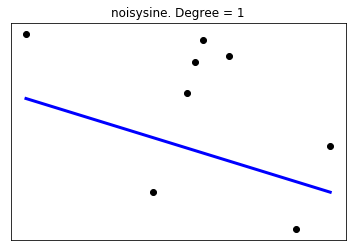

noisysine. Degree = 2. R2 score: -0.31762413696215264


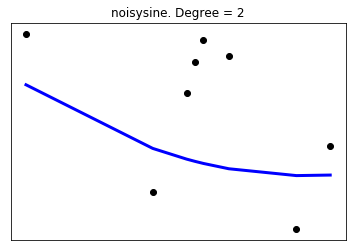

noisysine. Degree = 3. R2 score: -0.06869532201906758


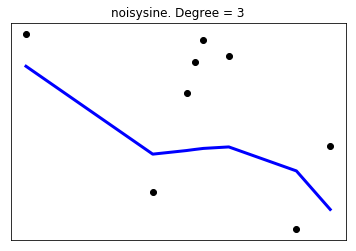

noisysine. Degree = 4. R2 score: -0.06789048544834175


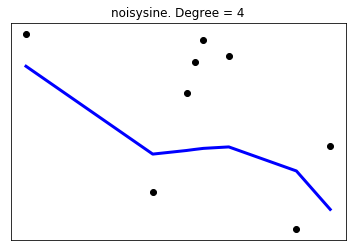

noisysine. Degree = 5. R2 score: 0.8250760122156561


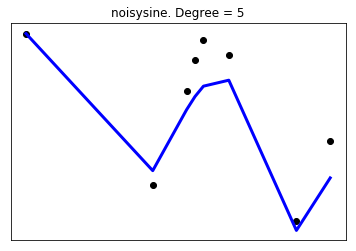

In [142]:
noisysine_degrees = [1, 2, 3, 4, 5]
for degree in noisysine_degrees:
    train_regression_and_print_results(noisysine_X_train, noisysine_X_val, noisysine_y_train, noisysine_y_val, 
                                       degree, True, "noisysine.", LinearRegression())

In [145]:
hydrodynamics_degrees = [1, 2]
for degree in hydrodynamics_degrees:
    train_regression_and_print_results(hydrodynamics_X_train, hydrodynamics_X_val, hydrodynamics_y_train, hydrodynamics_y_val, 
                                       degree, False, "hydrodynamics.", LinearRegression())

hydrodynamics. Degree = 1. R2 score: 0.6059339104296214
hydrodynamics. Degree = 2. R2 score: 0.9009525944306158


2.       (2) Implement a ridge regression algorithm and optimize the regularization parameter for every case from task #1.

In [176]:
class RidgeRegression:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def fit(self, X, y):
        self.w = np.linalg.inv(np.transpose(X) @ X + self.alpha * np.identity(X.shape[1])) @ np.transpose(X) @ y
    
    def predict(self, X):
        return X @ self.w

In [186]:
def optimize_ridge_regularization_parameter(X_train, X_val, y_train, y_val, degree, draw_graph, heading):
    alphas = [1 / 10 ** i for i in range(11)]
    r2_scores = np.empty((11,))
    for i, alpha in enumerate(alphas):
        regressor = RidgeRegression(alpha=alpha)
        print(str(i) + ". Alpha = " + str(alpha))
        r2_scores[i] = train_regression_and_print_results(X_train, X_val, y_train, y_val, degree, False, heading, regressor)
    best_score = np.max(r2_scores)
    best_alpha = alphas[np.argmax(r2_scores)]
    if draw_graph:
        regressor = RidgeRegression(alpha=best_alpha)
        train_regression_and_print_results(X_train, X_val, y_train, y_val, degree, True, heading, regressor)
    print("Best score = " + str(best_score) + " Best alpha = " + str(best_alpha))

0. Alpha = 1.0
noisysine. Degree = 1. R2 score: -0.22421769561748994
1. Alpha = 0.1
noisysine. Degree = 1. R2 score: -0.20944498862579697
2. Alpha = 0.01
noisysine. Degree = 1. R2 score: -0.2078690192075956
3. Alpha = 0.001
noisysine. Degree = 1. R2 score: -0.20771039639741318
4. Alpha = 0.0001
noisysine. Degree = 1. R2 score: -0.2076945238223309
5. Alpha = 1e-05
noisysine. Degree = 1. R2 score: -0.20769293646184694
6. Alpha = 1e-06
noisysine. Degree = 1. R2 score: -0.20769277772476857
7. Alpha = 1e-07
noisysine. Degree = 1. R2 score: -0.20769276185105068
8. Alpha = 1e-08
noisysine. Degree = 1. R2 score: -0.2076927602636789
9. Alpha = 1e-09
noisysine. Degree = 1. R2 score: -0.20769276010494164
10. Alpha = 1e-10
noisysine. Degree = 1. R2 score: -0.20769276008906812
noisysine. Degree = 1. R2 score: -0.20769276008906812


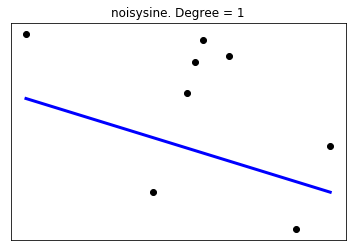

Best score = -0.20769276008906812 Best alpha = 1e-10
=====
0. Alpha = 1.0
noisysine. Degree = 2. R2 score: -0.29497732295197854
1. Alpha = 0.1
noisysine. Degree = 2. R2 score: -0.3144303627239913
2. Alpha = 0.01
noisysine. Degree = 2. R2 score: -0.317292066608561
3. Alpha = 0.001
noisysine. Degree = 2. R2 score: -0.3175907984630777
4. Alpha = 0.0001
noisysine. Degree = 2. R2 score: -0.31762080179291585
5. Alpha = 1e-05
noisysine. Degree = 2. R2 score: -0.31762380343202623
6. Alpha = 1e-06
noisysine. Degree = 2. R2 score: -0.3176241036090024
7. Alpha = 1e-07
noisysine. Degree = 2. R2 score: -0.31762413362682995
8. Alpha = 1e-08
noisysine. Degree = 2. R2 score: -0.31762413662861566
9. Alpha = 1e-09
noisysine. Degree = 2. R2 score: -0.3176241369288004
10. Alpha = 1e-10
noisysine. Degree = 2. R2 score: -0.31762413695881286
noisysine. Degree = 2. R2 score: -0.29497732295197854


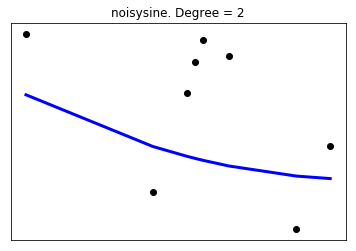

Best score = -0.29497732295197854 Best alpha = 1.0
=====
0. Alpha = 1.0
noisysine. Degree = 3. R2 score: -0.09806362183496331
1. Alpha = 0.1
noisysine. Degree = 3. R2 score: -0.0712762358747907
2. Alpha = 0.01
noisysine. Degree = 3. R2 score: -0.0689424888412491
3. Alpha = 0.001
noisysine. Degree = 3. R2 score: -0.06871991660999166
4. Alpha = 0.0001
noisysine. Degree = 3. R2 score: -0.06869778024356821
5. Alpha = 1e-05
noisysine. Degree = 3. R2 score: -0.06869556782918385
6. Alpha = 1e-06
noisysine. Degree = 3. R2 score: -0.06869534660001597
7. Alpha = 1e-07
noisysine. Degree = 3. R2 score: -0.06869532447717908
8. Alpha = 1e-08
noisysine. Degree = 3. R2 score: -0.06869532226488917
9. Alpha = 1e-09
noisysine. Degree = 3. R2 score: -0.06869532204371254
10. Alpha = 1e-10
noisysine. Degree = 3. R2 score: -0.06869532202153605
noisysine. Degree = 3. R2 score: -0.06869532202153605


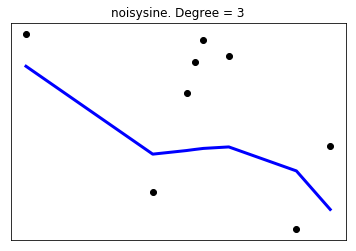

Best score = -0.06869532202153605 Best alpha = 1e-10
=====
0. Alpha = 1.0
noisysine. Degree = 4. R2 score: -0.1976071266158399
1. Alpha = 0.1
noisysine. Degree = 4. R2 score: -0.08619592485148653
2. Alpha = 0.01
noisysine. Degree = 4. R2 score: -0.0697966639451022
3. Alpha = 0.001
noisysine. Degree = 4. R2 score: -0.06808188979705454
4. Alpha = 0.0001
noisysine. Degree = 4. R2 score: -0.06790963377826009
5. Alpha = 1e-05
noisysine. Degree = 4. R2 score: -0.06789240035990995
6. Alpha = 1e-06
noisysine. Degree = 4. R2 score: -0.06789067694102169
7. Alpha = 1e-07
noisysine. Degree = 4. R2 score: -0.06789050459771984
8. Alpha = 1e-08
noisysine. Degree = 4. R2 score: -0.06789048736385883
9. Alpha = 1e-09
noisysine. Degree = 4. R2 score: -0.06789048563992095
10. Alpha = 1e-10
noisysine. Degree = 4. R2 score: -0.06789048546807375
noisysine. Degree = 4. R2 score: -0.06789048546807375


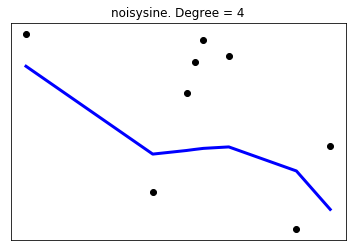

Best score = -0.06789048546807375 Best alpha = 1e-10
=====
0. Alpha = 1.0
noisysine. Degree = 5. R2 score: 0.8112686053718534
1. Alpha = 0.1
noisysine. Degree = 5. R2 score: 0.8236411814950584
2. Alpha = 0.01
noisysine. Degree = 5. R2 score: 0.8249312015628266
3. Alpha = 0.001
noisysine. Degree = 5. R2 score: 0.8250615165182107
4. Alpha = 0.0001
noisysine. Degree = 5. R2 score: 0.8250745624951215
5. Alpha = 1e-05
noisysine. Degree = 5. R2 score: 0.8250758672253382
6. Alpha = 1e-06
noisysine. Degree = 5. R2 score: 0.8250759976847573
7. Alpha = 1e-07
noisysine. Degree = 5. R2 score: 0.8250760107394997
8. Alpha = 1e-08
noisysine. Degree = 5. R2 score: 0.8250760120436609
9. Alpha = 1e-09
noisysine. Degree = 5. R2 score: 0.8250760122079319
10. Alpha = 1e-10
noisysine. Degree = 5. R2 score: 0.8250760121985992
noisysine. Degree = 5. R2 score: 0.8250760122079319


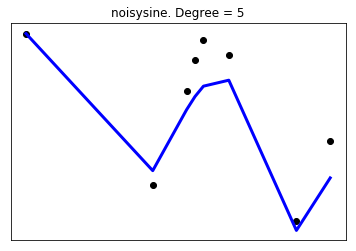

Best score = 0.8250760122079319 Best alpha = 1e-09
=====


In [187]:
noisysine_degrees = [1, 2, 3, 4, 5]
for degree in noisysine_degrees:
    optimize_ridge_regularization_parameter(noisysine_X_train, noisysine_X_val, noisysine_y_train, noisysine_y_val, 
                                       degree, True, "noisysine.")
    print("=====")

In [178]:
hydrodynamics_degrees = [1, 2]
for degree in hydrodynamics_degrees:
    optimize_ridge_regularization_parameter(hydrodynamics_X_train, hydrodynamics_X_val, hydrodynamics_y_train, hydrodynamics_y_val, 
                                       degree, False, "hydrodynamics.")
    print("=====")

0. Alpha = 1.0
hydrodynamics. Degree = 1. R2 score: 0.5891340849103469
1. Alpha = 0.1
hydrodynamics. Degree = 1. R2 score: 0.6116654486366047
2. Alpha = 0.01
hydrodynamics. Degree = 1. R2 score: 0.606771328338455
3. Alpha = 0.001
hydrodynamics. Degree = 1. R2 score: 0.6060259184419736
4. Alpha = 0.0001
hydrodynamics. Degree = 1. R2 score: 0.6059432252641732
5. Alpha = 1e-05
hydrodynamics. Degree = 1. R2 score: 0.6059348430992559
6. Alpha = 1e-06
hydrodynamics. Degree = 1. R2 score: 0.6059340037088661
7. Alpha = 1e-07
hydrodynamics. Degree = 1. R2 score: 0.6059339197574996
8. Alpha = 1e-08
hydrodynamics. Degree = 1. R2 score: 0.6059339113618833
9. Alpha = 1e-09
hydrodynamics. Degree = 1. R2 score: 0.6059339105226882
10. Alpha = 1e-10
hydrodynamics. Degree = 1. R2 score: 0.6059339104387385
Best score = 0.6116654486366047 Best alpha = 0.1
=====
0. Alpha = 1.0
hydrodynamics. Degree = 2. R2 score: 0.6146980593266171
1. Alpha = 0.1
hydrodynamics. Degree = 2. R2 score: 0.6950610687125593
2. A

3.       (3) Use the LASSO regression algorithm (i.e., from the sklearn package) and optimize regularization parameters for every case from task #1. Output the number of used features.

In [227]:
def optimize_lasso_regularization_parameter(X_train, X_val, y_train, y_val, degree, draw_graph, heading):
    from sklearn import linear_model
    number_of_alphas = 11
    alphas = [1 / 10 ** i for i in range(number_of_alphas)]
    r2_scores = np.empty((number_of_alphas,))
    for i, alpha in enumerate(alphas):
        regressor = linear_model.Lasso(alpha=alpha, max_iter=10000)
        print(str(i) + ". Alpha = " + str(alpha))
        r2_scores[i] = train_regression_and_print_results(X_train, X_val, y_train, y_val, degree, False, heading, regressor)
    best_score = np.max(r2_scores)
    best_alpha = alphas[np.argmax(r2_scores)]
    best_regressor = linear_model.Lasso(alpha=best_alpha)
    train_regression_and_print_results(X_train, X_val, y_train, y_val, degree, draw_graph, heading, best_regressor)    
    print("Best score = " + str(best_score) + " Best alpha = " + str(best_alpha) + " Number of used features = " + str((best_regressor.coef_ != 0).sum()))

0. Alpha = 1.0
noisysine. Degree = 1. R2 score: -0.18837184346659996
1. Alpha = 0.1
noisysine. Degree = 1. R2 score: -0.20466900326884074
2. Alpha = 0.01
noisysine. Degree = 1. R2 score: -0.20737946775389404
3. Alpha = 0.001
noisysine. Degree = 1. R2 score: -0.2076613216874479
4. Alpha = 0.0001
noisysine. Degree = 1. R2 score: -0.20768961515565332
5. Alpha = 1e-05
noisysine. Degree = 1. R2 score: -0.20769244558322253
6. Alpha = 1e-06
noisysine. Degree = 1. R2 score: -0.2076927286367869
7. Alpha = 1e-07
noisysine. Degree = 1. R2 score: -0.20769275694225153
8. Alpha = 1e-08
noisysine. Degree = 1. R2 score: -0.2076927597727991
9. Alpha = 1e-09
noisysine. Degree = 1. R2 score: -0.20769276005585402
10. Alpha = 1e-10
noisysine. Degree = 1. R2 score: -0.20769276008415893
noisysine. Degree = 1. R2 score: -0.18837184346659996


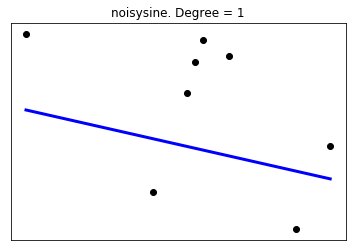

Best score = -0.18837184346659996 Best alpha = 1.0 Number of used features = 1
=====
0. Alpha = 1.0
noisysine. Degree = 2. R2 score: -0.14957065469202568
1. Alpha = 0.1
noisysine. Degree = 2. R2 score: -0.2696562705616803
2. Alpha = 0.01
noisysine. Degree = 2. R2 score: -0.3124677469145445
3. Alpha = 0.001
noisysine. Degree = 2. R2 score: -0.31710512669617197
4. Alpha = 0.0001
noisysine. Degree = 2. R2 score: -0.31757220820952736
5. Alpha = 1e-05
noisysine. Degree = 2. R2 score: -0.3176189444042148
6. Alpha = 1e-06
noisysine. Degree = 2. R2 score: -0.31762361776848014
7. Alpha = 1e-07
noisysine. Degree = 2. R2 score: -0.31762408504924955
8. Alpha = 1e-08
noisysine. Degree = 2. R2 score: -0.31762413177150206
9. Alpha = 1e-09
noisysine. Degree = 2. R2 score: -0.317624136443148
10. Alpha = 1e-10
noisysine. Degree = 2. R2 score: -0.31762413691020686
noisysine. Degree = 2. R2 score: -0.14957065469202568


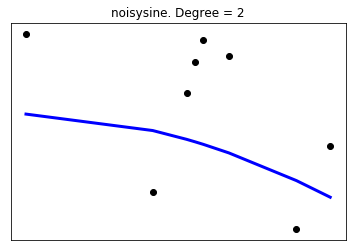

Best score = -0.14957065469202568 Best alpha = 1.0 Number of used features = 1
=====
0. Alpha = 1.0
noisysine. Degree = 3. R2 score: -0.20834375157238028
1. Alpha = 0.1
noisysine. Degree = 3. R2 score: -0.10442041161184057
2. Alpha = 0.01
noisysine. Degree = 3. R2 score: -0.07158773481287106
3. Alpha = 0.001
noisysine. Degree = 3. R2 score: -0.06897788975392372
4. Alpha = 0.0001
noisysine. Degree = 3. R2 score: -0.0687235124329475
5. Alpha = 1e-05
noisysine. Degree = 3. R2 score: -0.06869814040001865
6. Alpha = 1e-06
noisysine. Degree = 3. R2 score: -0.06869560385086082
7. Alpha = 1e-07
noisysine. Degree = 3. R2 score: -0.06869535020207929
8. Alpha = 1e-08
noisysine. Degree = 3. R2 score: -0.06869532483738428
9. Alpha = 1e-09
noisysine. Degree = 3. R2 score: -0.068695322300937
10. Alpha = 1e-10
noisysine. Degree = 3. R2 score: -0.06869532204762119
noisysine. Degree = 3. R2 score: -0.07840141476485107


/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


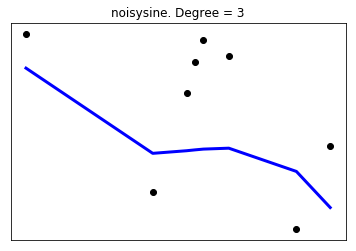

Best score = -0.06869532204762119 Best alpha = 1e-10 Number of used features = 3
=====
0. Alpha = 1.0
noisysine. Degree = 4. R2 score: -0.2865749008236371
1. Alpha = 0.1
noisysine. Degree = 4. R2 score: -0.25576322562068565
2. Alpha = 0.01
noisysine. Degree = 4. R2 score: -0.1072200014355289
3. Alpha = 0.001
noisysine. Degree = 4. R2 score: -0.08948495222113295
4. Alpha = 0.0001
noisysine. Degree = 4. R2 score: -0.0877236204165801
5. Alpha = 1e-05
noisysine. Degree = 4. R2 score: -0.08754760896727776
6. Alpha = 1e-06
noisysine. Degree = 4. R2 score: -0.08753000903970198
7. Alpha = 1e-07
noisysine. Degree = 4. R2 score: -0.0875282490591176
8. Alpha = 1e-08
noisysine. Degree = 4. R2 score: -0.08752807306113142
9. Alpha = 1e-09
noisysine. Degree = 4. R2 score: -0.087528055461356
10. Alpha = 1e-10
noisysine. Degree = 4. R2 score: -0.08752805370137429
noisysine. Degree = 4. R2 score: -0.11497574710922964


/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

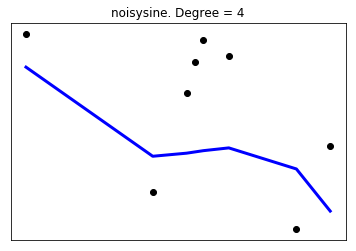

Best score = -0.08752805370137429 Best alpha = 1e-10 Number of used features = 4
=====
0. Alpha = 1.0
noisysine. Degree = 5. R2 score: -0.1418842249326544
1. Alpha = 0.1
noisysine. Degree = 5. R2 score: 0.027833624467081153
2. Alpha = 0.01
noisysine. Degree = 5. R2 score: 0.18072219757965824
3. Alpha = 0.001
noisysine. Degree = 5. R2 score: 0.19655020262662937
4. Alpha = 0.0001
noisysine. Degree = 5. R2 score: 0.1981186986260255
5. Alpha = 1e-05
noisysine. Degree = 5. R2 score: 0.19827540583886527
6. Alpha = 1e-06
noisysine. Degree = 5. R2 score: 0.19829107513765964
7. Alpha = 1e-07
noisysine. Degree = 5. R2 score: 0.19829264205344188
8. Alpha = 1e-08


/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

noisysine. Degree = 5. R2 score: 0.1982927987447365
9. Alpha = 1e-09
noisysine. Degree = 5. R2 score: 0.19829281441392665
10. Alpha = 1e-10
noisysine. Degree = 5. R2 score: 0.19829281598081716
noisysine. Degree = 5. R2 score: -0.06651358592507495


/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


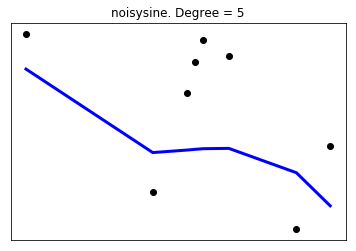

Best score = 0.19829281598081716 Best alpha = 1e-10 Number of used features = 5
=====


In [228]:
noisysine_degrees = [1, 2, 3, 4, 5]
for degree in noisysine_degrees:
    optimize_lasso_regularization_parameter(noisysine_X_train, noisysine_X_val, noisysine_y_train, noisysine_y_val, 
                                       degree, True, "noisysine.")
    print("=====")

In [229]:
hydrodynamics_degrees = [1, 2]
for degree in hydrodynamics_degrees:
    optimize_lasso_regularization_parameter(hydrodynamics_X_train, hydrodynamics_X_val, hydrodynamics_y_train, hydrodynamics_y_val, 
                                       degree, False, "hydrodynamics.")
    print("=====")

0. Alpha = 1.0
hydrodynamics. Degree = 1. R2 score: 0.2579391541870054
1. Alpha = 0.1
hydrodynamics. Degree = 1. R2 score: 0.6155843211342705
2. Alpha = 0.01
hydrodynamics. Degree = 1. R2 score: 0.6094145835514884
3. Alpha = 0.001
hydrodynamics. Degree = 1. R2 score: 0.6063924987241844
4. Alpha = 0.0001
hydrodynamics. Degree = 1. R2 score: 0.6059806146368156
5. Alpha = 1e-05
hydrodynamics. Degree = 1. R2 score: 0.6059385892912025
6. Alpha = 1e-06
hydrodynamics. Degree = 1. R2 score: 0.6059343784423672
7. Alpha = 1e-07
hydrodynamics. Degree = 1. R2 score: 0.6059339572305658
8. Alpha = 1e-08
hydrodynamics. Degree = 1. R2 score: 0.6059339151095542
9. Alpha = 1e-09
hydrodynamics. Degree = 1. R2 score: 0.6059339108975396
10. Alpha = 1e-10
hydrodynamics. Degree = 1. R2 score: 0.6059339104763475
hydrodynamics. Degree = 1. R2 score: 0.6155843211342705
Best score = 0.6155843211342705 Best alpha = 0.1 Number of used features = 3
=====
0. Alpha = 1.0
hydrodynamics. Degree = 2. R2 score: 0.6125393

/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

hydrodynamics. Degree = 2. R2 score: 0.9061073319480167
6. Alpha = 1e-06
hydrodynamics. Degree = 2. R2 score: 0.905459192414784
7. Alpha = 1e-07
hydrodynamics. Degree = 2. R2 score: 0.9053932829265343
8. Alpha = 1e-08
hydrodynamics. Degree = 2. R2 score: 0.9053866808980842
9. Alpha = 1e-09
hydrodynamics. Degree = 2. R2 score: 0.9053860205826701
10. Alpha = 1e-10
hydrodynamics. Degree = 2. R2 score: 0.9053859545500229
hydrodynamics. Degree = 2. R2 score: 0.9110099003837228
Best score = 0.9109704947576581 Best alpha = 0.001 Number of used features = 19
=====


/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mikhail/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

# Global and Local Search

Dataset: tsp.csv - coordinates of points to visit.

In every task, you need to visualize the best-found path and output its length. The path is not cyclical, i.e., the starting and finishing points are not the same.

NOTICE - the distance should be in L1 (avenues and streets). The path should be drawn as L1 as well.

In [3]:
# tsp.csv loading
tsp_path = dataset_root + 'tsp.csv'
tsp_data = pd.read_csv(tsp_path)
tsp_data = tsp_data.values
tsp_X = tsp_data[:, 1:].astype('float64')
print("tsp coordinates shape: " + str(tsp_X.shape))

tsp coordinates shape: (51, 2)


In [29]:
def f_to_optimize(X):
    return np.array([distance.cityblock(X[i], X[i - 1]) for i in range(1, X.shape[0])]).sum()

def draw_path(X, title):
    plt.scatter(X[:, 0], X[:, 1],  color='red')
    L1_path = np.array([[X[int(i / 2)][0], X[int(i / 2) + i % 2][1]] for i in range(2 * X.shape[0] - 1)])
    plt.plot(L1_path[:, 0], L1_path[:, 1])

    plt.title(title)
    plt.show()

26885.0


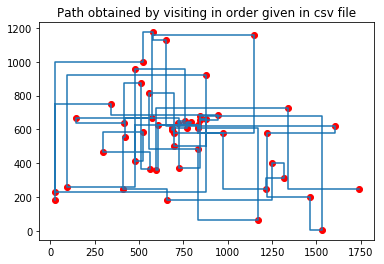

In [31]:
print(f_to_optimize(tsp_X))
draw_path(tsp_X, "Path obtained by visiting in order given in csv file")

In [105]:
def conduct_optimization_experiment(optimizer, optimizer_name):
    print("Optimization by " + optimizer_name)
    np.random.seed(global_random_seed)
    best_X, best_value = optimizer(f_to_optimize, tsp_X)
    print("Total distance: " + str(best_value))
    draw_path(best_X, "Path obtained by " + optimizer_name + " method")

4. (2) Implement a Monte-Carlo search.

In [106]:
def optimize_monte_carlo(f, X, iters=1000):
    best_X = X.copy()
    np.random.shuffle(best_X)
    best_value = f(best_X)
    new_X = best_X.copy()
    for i in range(iters):
        np.random.shuffle(new_X)
        new_value = f(new_X)
        if new_value < best_value:
            best_value = new_value
            best_x = new_X
    return best_X, best_value

Optimization by Monte Carlo
Total distance: 29630.0


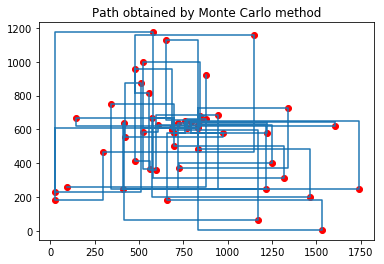

In [107]:
conduct_optimization_experiment(optimize_monte_carlo, "Monte Carlo")

5. (2) Implement a random walk search.

In [108]:
def optimize_random_walk(f, X, dist=np.random.uniform):
    indices_to_visit = []
    indices = [i for i in range(X.shape[0])]
    for i in reversed(range(X.shape[0])):
        index_to_select = int(dist(0, i + 1))
        indices_to_visit.append(indices[index_to_select])
        indices.remove(indices[index_to_select])
    return X[indices_to_visit], f(X[indices_to_visit])

Optimization by Random Walk
Total distance: 37145.0


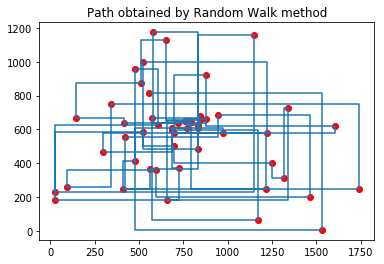

In [109]:
conduct_optimization_experiment(optimize_random_walk, "Random Walk")

6. (4) Implement a hill climb algorithm.

In [121]:
def swap_several_vertices_randomly(X, num_of_next=None, dist=np.random.uniform):
    if num_of_next is None:
        num_of_next = int(0.2 * X.shape[0])
    for i in range(num_of_next):
        new_X = X.copy()
        i, j = int(dist(0, X.shape[0])), int(dist(0, X.shape[0]))
        while i == j:
            i, j = int(dist(0, X.shape[0])), int(dist(0, X.shape[0]))
        new_X[[i, j]] = new_X[[j, i]]
        yield new_X

def swap_specific_vertice_with_others(X, vertice_index):
    for i in range(X.shape[0] - 1):
        if i == vertice_index:
            continue
        new_X = X.copy()
        new_X[[i, vertice_index]] = new_X[[vertice_index, i]]
        yield new_X
        
def optimize_hill_climb(f, X, move_operator=swap_specific_vertice_with_others, max_iters=1000):
    best = X.copy()
    np.random.shuffle(best)
    best_score = f(best)
    for i in range(max_iters):
        move_made=False
        vertice_index_to_swap = i % X.shape[0]
        for next_point in move_operator(best, vertice_index_to_swap):
            next_score = f(next_point)
            if next_score < best_score:
                best = next_point
                best_score = next_score
                move_made = True
        
        if not move_made:
            break
    
    return best, best_score

Optimization by Hill Climb
Total distance: 21090.0


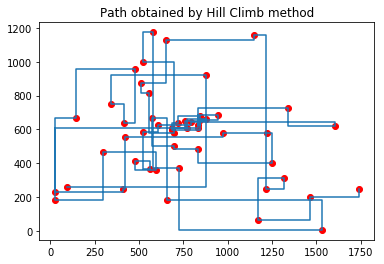

In [122]:
conduct_optimization_experiment(optimize_hill_climb, "Hill Climb")

7. (6) Implement a simulated annealing algorithm.

In [146]:
def optimize_simulated_annealing(f, X, move_operator=swap_specific_vertice_with_others, max_iters=1000):
    def calculate_T(i):
        T_max = 1000
        T_min = 0.0001
        return T_max - (T_max - T_min) * i / max_iters
    current_point = X.copy()
    np.random.shuffle(current_point)
    current_score = f(current_point)
    for i in range(max_iters):
        vertice_index_to_swap = i % X.shape[0]
        next_points = np.array([next_point for next_point in move_operator(current_point, vertice_index_to_swap)])
        scores_delta = np.array([current_score - f(next_points[i]) for i in range(next_points.shape[0])])
        T = calculate_T(i)
        proba = softmax(scores_delta / T)
        current_point = next_points[np.random.choice(next_points.shape[0], p=proba)]
        current_score = f(current_point)
    
    return current_point, current_score

Optimization by Simulated Annealing
Total distance: 12780.0


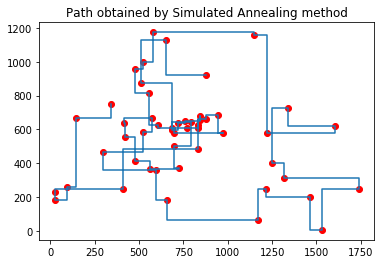

In [147]:
conduct_optimization_experiment(optimize_simulated_annealing, "Simulated Annealing")

8. (8) Implement a genetic algorithm.

In [251]:
 def make_crossover(point1, point2, index_to_split=None):
        point1 = point1.copy()
        point2 = point2.copy()
        num_of_coordinates = point1.shape[0]
        if index_to_split is None:
            index_to_split = int(np.random.uniform(1, num_of_coordinates))
        add_to_point1 = []
        for i in range(num_of_coordinates):
            if point2[i].tolist() not in point1[:index_to_split].tolist():
                add_to_point1.append(point2[i].copy())
        add_to_point2 = []
        for i in range(num_of_coordinates):
            if point1[i].tolist() not in point2[:index_to_split].tolist():
                add_to_point2.append(point1[i].copy())
        for i in range(index_to_split, num_of_coordinates):
            point1[i] = add_to_point1[i - index_to_split]
            point2[i] = add_to_point2[i - index_to_split]
        return point1, point2

def mutate(point, mutationRate=0.05):
        point = point.copy()
        for swapped in range(point.shape[0]):
            if(np.random.uniform(0, 1) < mutationRate):
                swap_with = int(np.random.uniform(0, point.shape[0]))
                point[[swapped, swap_with]] = point[[swap_with, swapped]]
        return point

def optimize_genetic(f, X, max_iters=1000, population_size=20):
    population = np.array([np.random.permutation(X) for i in range(population_size)])
    population_scores = np.array([f(population[i]) for i in range(population_size)])
    for i in range(max_iters):
        arg_sorted = np.argsort(population_scores)
        point1 = population[arg_sorted[0]]
        point2 = population[arg_sorted[1]]
        point1, point2 = make_crossover(point1, point2)
        point1, point2 = mutate(point1), mutate(point2)
        population[arg_sorted[-1]] = point1
        population[arg_sorted[-2]] = point2
        population_scores = np.array([f(population[i]) for i in range(population_size)])
    arg_sorted = np.argsort(population_scores)
    return population[arg_sorted[0]], population_scores[arg_sorted[0]]

Optimization by Genetic Algorithm
Total distance: 15630.0


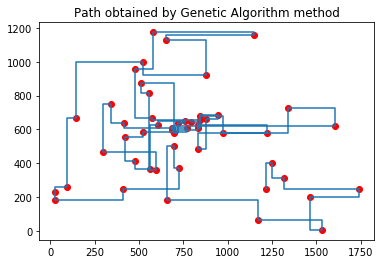

In [252]:
conduct_optimization_experiment(optimize_genetic, "Genetic Algorithm")